#  Sentiment Analysis on Amazon Reviews


 #  Import Libraries
 

In [12]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from wordcloud import WordCloud
from collections import Counter

# NLP + ML
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (8,5)



 #  Load Dataset
 

In [13]:
df = pd.read_csv("Reviews.csv")  # use your file
df.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [14]:
print(df.info())
print(df['Score'].value_counts())




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB
None
Score
5    363122
4     80655
1     52268
3     42640
2     29769
Name: count, dtype: int64


# Create sentiment label


In [15]:
def sentiment(score):
    if score <= 2:
        return "Negative"
    elif score == 3:
        return "Neutral"
    else:
        return "Positive"

df['Sentiment'] = df['Score'].apply(sentiment)
df[['Score','Sentiment']].head()

,Score,Sentiment
0,5,Positive
1,1,Negative
2,4,Positive
3,2,Negative
4,5,Positive


#   Text Cleaning


In [16]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)  # remove links
    text = re.sub(r"<.*?>", "", text)    # remove HTML
    text = text.translate(str.maketrans("", "", string.punctuation))  # remove punctuation
    text = re.sub(r"\d+", "", text)  # remove numbers
    text = text.strip()
    return text

df['Cleaned_Text'] = df['Text'].apply(clean_text)
df[['Text','Cleaned_Text']].head()


,Text,Cleaned_Text
0,I have bought several of the Vitality canned d...,i have bought several of the vitality canned d...
1,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled as jumbo salted peanut...
2,This is a confection that has been around a fe...,this is a confection that has been around a fe...
3,If you are looking for the secret ingredient i...,if you are looking for the secret ingredient i...
4,Great taffy at a great price. There was a wid...,great taffy at a great price there was a wide...


#   Exploratory Data Analysis


/var/folders/jx/zcfwn8ds7wncqbhz7xcskktw0000gn/T/ipykernel_69339/1068570798.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=df, palette='Set2')


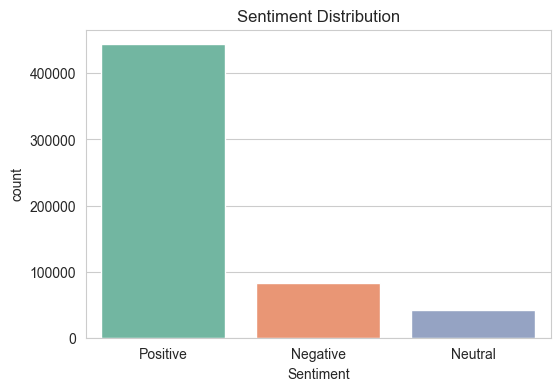

Sentiment
Positive    78.067355
Negative    14.431599
Neutral      7.501047
Name: proportion, dtype: float64


In [17]:
# Class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Sentiment', data=df, palette='Set2')
plt.title("Sentiment Distribution")
plt.show()

print(df['Sentiment'].value_counts(normalize=True)*100)

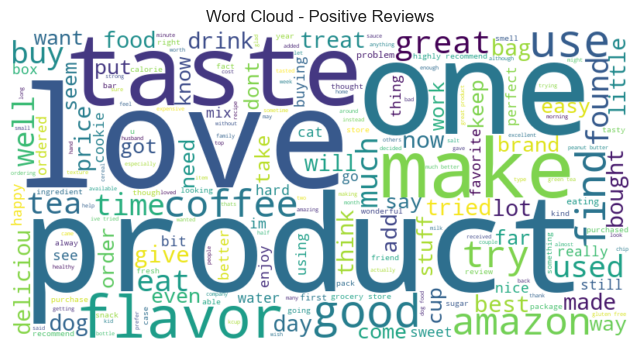

In [18]:
positive_text = " ".join(df[df['Sentiment']=="Positive"]["Cleaned_Text"])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(positive_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Positive Reviews")
plt.show()


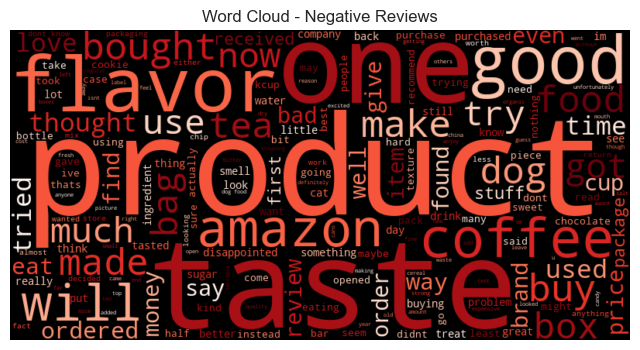

In [19]:
negative_text = " ".join(df[df['Sentiment']=="Negative"]["Cleaned_Text"])
wordcloud = WordCloud(width=800, height=400, background_color="black", colormap="Reds").generate(negative_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Negative Reviews")
plt.show()


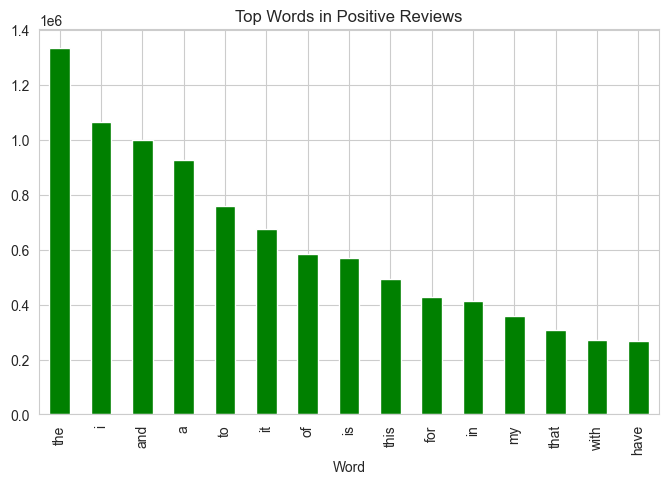

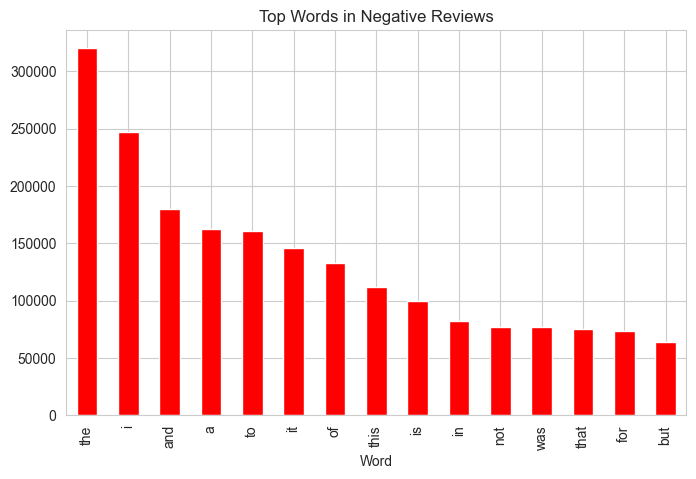

In [20]:
# Top words
top_positive = Counter(positive_text.split()).most_common(15)
pd.DataFrame(top_positive, columns=['Word','Count']).plot.bar(x='Word', y='Count', legend=False, color='green', title="Top Words in Positive Reviews")
plt.show()

top_negative = Counter(negative_text.split()).most_common(15)
pd.DataFrame(top_negative, columns=['Word','Count']).plot.bar(x='Word', y='Count', legend=False, color='red', title="Top Words in Negative Reviews")
plt.show()

# Prepare Data

In [21]:
# Features & labels
X = df['Cleaned_Text']
y = df['Sentiment']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


# Model Training & Evaluation

In [22]:
log_model = LogisticRegression(max_iter=200)
log_model.fit(X_train_tfidf, y_train)
y_pred_log = log_model.predict(X_test_tfidf)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))


Logistic Regression Accuracy: 0.8632785356800451
              precision    recall  f1-score   support

    Negative       0.73      0.66      0.69     16407
     Neutral       0.52      0.17      0.25      8528
    Positive       0.89      0.97      0.93     88756

    accuracy                           0.86    113691
   macro avg       0.71      0.60      0.62    113691
weighted avg       0.84      0.86      0.84    113691



In [23]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))


Naive Bayes Accuracy: 0.8160100623620163
              precision    recall  f1-score   support

    Negative       0.83      0.27      0.41     16407
     Neutral       0.64      0.00      0.01      8528
    Positive       0.82      0.99      0.90     88756

    accuracy                           0.82    113691
   macro avg       0.76      0.42      0.44    113691
weighted avg       0.80      0.82      0.76    113691



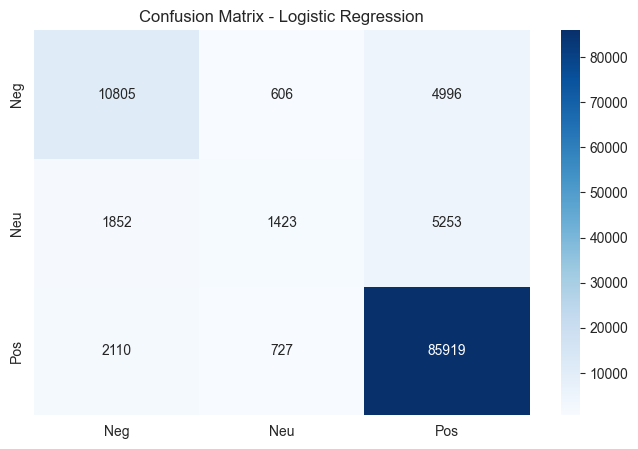

In [24]:
cm = confusion_matrix(y_test, y_pred_log, labels=["Negative","Neutral","Positive"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Neg","Neu","Pos"], yticklabels=["Neg","Neu","Pos"])
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


In [25]:
# Compare models visually
models = ['Logistic Regression', 'Naive Bayes']
accuracy = [accuracy_score(y_test, y_pred_log), accuracy_score(y_test, y_pred_nb)]


/var/folders/jx/zcfwn8ds7wncqbhz7xcskktw0000gn/T/ipykernel_69339/2680931682.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracy, palette="pastel")


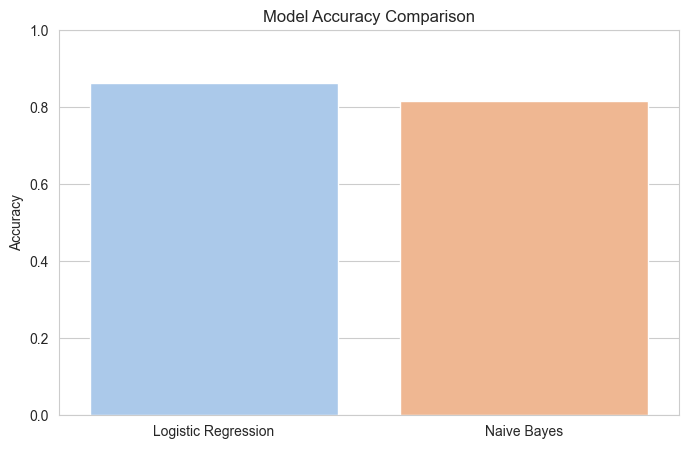

In [26]:
sns.barplot(x=models, y=accuracy, palette="pastel")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()

## Key Insights from Amazon Reviews Sentiment Analysis

- Positive reviews dominate the dataset, followed by negative and neutral reviews.
- Word clouds show positive reviews often include words like 'good', 'love', 'best', 
  while negative reviews contain words like 'bad', 'waste', 'not'.
- Logistic Regression performed slightly better than Naive Bayes on this dataset.
- Confusion matrix shows the model struggles a bit with neutral reviews due to smaller sample size.
- Analyzing top words gives insight into customer concerns and satisfaction trends.
 